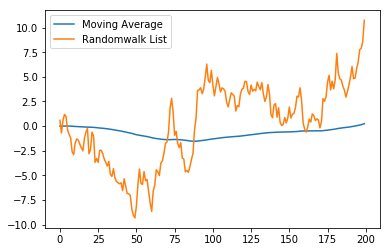

In [37]:
import numpy as np
import matplotlib.pyplot as plt
L=200
say=0
mova=0
lst=[]
lstmv=[]
for i in range (L):
    say=say+np.random.randn()
    lst.append(say)
for x in lst: 
    mova=x+mova
    lstmv.append(mova/200)
plt.plot(lstmv,  label='Moving Average')
plt.plot(lst,   label='Randomwalk List')
plt.legend()
plt.show()

In [ ]:
#europe option pricing
import numpy as np
r=0.05
S0=100
K=110
sigma=0.1
T=1
C=0
P=0
N=1000
for i in range(N):
    W=np.random.randn()*np.sqrt(T)
    S1=S0*math.exp((r-0.05*sigma**2)*T+sigma*W)
    C+=max(0,S1-K)
    P+=max(0,K-S1)
call_price=(C/N)*np.exp(-r*T)
put_price=(P/N)*np.exp(-r*T)
print(call_price)
print(put_price)

In [ ]:
#american option
def MC2(option,params):  
      
    #antithetic  
    AP=params.AP  
    #moment matching  
    MM=params.MM  
      
    #number of time steps and of paths  
    NTS=params.NTS  
    NP=params.NP  
    [S0,K,sigma,T,r2,divi,american]=[float(option.S0),float(option.K),option.sigma,float(option.T),option.r,option.divi,option.american]  
          
      
    #we process the random variables  
    def RNG(I):  
        if AP == True :  
            ran = np.random.standard_normal (I/2)  
            ran = np.concatenate (( ran ,- ran ))  
        else :  
            ran = np.random.standard_normal (I)  
        if MM == True :  
            ran =ran - np.mean ( ran)  
            ran = ran / np.std ( ran )  
        return ran  
      
    dt=float(T)/NTS  
    np.random.seed  
      
    dividends,dividendsStep=preparedivs(divi,T,dt)  
    r,rArray,rateChangeStep,DFArray=preparerates(r2,T,dt,NTS)  
          
    # generate stock price paths  
    S= np.zeros ((NTS+1,NP),'d') # index level matrix  
    S[0 ,:]= S0 # initial values  
    rr=r[1][1]  
    for t in range (1,NTS+1): # loop over the days  
        ran = RNG (NP)  
          
        if (t in rateChangeStep[:]):  
          rr= (r[1][np.nonzero(rateChangeStep==(t))[0]+1])  
            
            
        S[t ,:]= S[t-1 ,:]* np.exp ((rr-0.5*sigma **2)* dt+ sigma * ran * np.sqrt (dt ))  
        if (t in dividendsStep):  
            div=dividends[1][np.nonzero(dividendsStep==(t))[0]]    
            S[t,:]=np.maximum(S[t,:]-div,0)  
          
    #american option handling  
    warnings.simplefilter('ignore', np.RankWarning)  
    if american==True:      
        VC=np.maximum(S-K,0)  
        VP=np.maximum(K-S,0)  
        hC=VC  
        hP=VP  
        deg=2  
        for t in range(NTS-1,-1,-1):  
            df=DFArray[t]  
  
            #get the ITM call  
            dummy=np.greater(hC[t,:],0)  
            relevant=np.nonzero(dummy)  
            relevantS=np.compress(dummy,S[t,:])  
            p=len(relevantS)  
            #if any  
            if p==0:  
                contvalues=np.zeros((NP))  
            else:  
                relevantV=np.compress(dummy,VC[t+1,:]*df)  
                #rg is an approximation of the call price as a function of the stock                  
                #only in the ITM region  
                #to fit that function we discount call prices from the next time step (we go backward in time)  
                rg=np.polyfit(relevantS[:],relevantV[:],deg)                
                contvalues=np.polyval(rg,relevantS[:])  
                  
            #for each call we check if exercise now is higher than approximate value of keeping it      
            erg=np.zeros((NP))  
            np.put(erg,relevant,contvalues)  
            VC[t,:]=np.where(hC[t,:]>erg,hC[t,:],VC[t+1,:]*df)  
              
            #then do teh same for the puts  
            dummy=np.greater(hP[t,:],0)  
            relevant=np.nonzero(dummy)  
            relevantS=np.compress(dummy,S[t,:])  
            p=len(relevantS)  
            #if any  
            if p==0:  
                contvalues=np.zeros((NP))  
            else:  
                relevantV=np.compress(dummy,VP[t+1,:]*df)  
                #rg is an approximation of the put price as a function of the stock                  
                #only in the ITM region  
                #to fit that function we discount put prices from the next time step (we go backward in time)  
                rg=np.polyfit(relevantS[:],relevantV[:],deg)                
                contvalues=np.polyval(rg,relevantS[:])  
                  
            #for each put we check if exercise now is higher than approximate value of keeping it      
            erg=np.zeros((NP))  
            np.put(erg,relevant,contvalues)  
            VP[t,:]=np.where(hP[t,:]>erg,hP[t,:],VP[t+1,:]*df)  
              
              
              
              
        option.call.price=sum(VC[0,:])/NP  
        option.put.price=sum(VP[0,:])/NP  
          
    else:          
        df=np.prod(DFArray[1:NTS+1])  
        VC=np.maximum(S[-1][:]-K,0)  
        option.call.price=df*sum(VC)/NP  
        VP=np.maximum(-S[-1][:]+K,0)  
        option.put.price=df*sum(VP)/NP  
          
    return VC     



#we use function to preprate divs and rates, that's cleaner  
def preparedivs(divi,T,dt):  
        dividends=[[],[]]   
        #2 columns vector, one for amount one for time.  
        #we make sure we don't take into account dividend happening after expiration  
     
        if (np.size(divi)>0 and divi[0][0]<T) :  
            lastdiv=np.nonzero(np.array(divi[0][:])<=T)[0][-1]  
            dividends[0]=divi[0][:lastdiv+1]          
            dividends[1]=divi[1][:lastdiv+1]   
      
        #Transform the dividend date into a step  
        if np.size(dividends)>0:  
            dividendsStep=np.floor(np.multiply(dividends[0],1/dt))  
        else:  
            dividendsStep=[]   
        return dividends,dividendsStep  
      
def preparerates(r2,T,dt,NTS):  
        r=[[],[]]  
          
        #similar structure for rates  
        # rates with date d1 is use until date d1 so we need the first date post maturity.     
        if np.size(r2)>0 :  
            lastrate=np.nonzero(np.array(r2[0][:])<=T)[0][-1]  
            r[0]=r2[0][:lastrate+2]          
            r[1]=r2[1][:lastrate+2]         
        if np.size(r)>0:  
            rateChangeStep=np.floor(np.multiply(r[0],1/dt))  
        else:  
            rateChangeStep=[]        
          
        #prepare the array for rates used for the PDE  
        rArray=np.zeros((NTS+2,1),float)     
        DFArray=np.zeros((NTS+2,1),float)  
      
        #get the steps where the rate changes  
        prevstep=0  
          
        for step in range(len(rateChangeStep)):  
            DFArray[prevstep:rateChangeStep[step]]=np.exp(-r[1][step]*dt)  
            rArray[prevstep:rateChangeStep[step]]=r[1][step]  
            prevstep=rateChangeStep[step]  
  
       
        rArray[0]=rArray[1]     
          
        return r,rArray,rateChangeStep,DFArray 


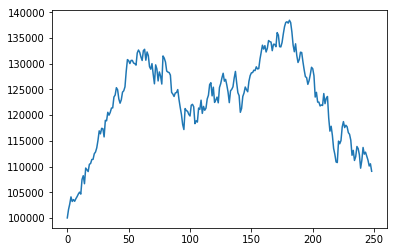

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
MST=[]
APPL=[]
K=100000
p=0.6
r=0.01
APLLEST=0
MICRST=0
TOTAL_WEALTH=[]
Apstocknum=0
MSstocknum=0

msft = pd.read_csv("msft.csv", index_col=0, parse_dates=True)
aapl = pd.read_csv("aapl.csv", index_col=0, parse_dates=True)

MST=msft.loc["2012-01-03":"2012-12-28","Close"]
APPL=aapl.loc["2012-01-03":"2012-12-28","Close"]
Apstocknum=K*(1-p)/APPL[0]
MSstocknum=K*p/MST[0]
for i in range(len(MST)):
    #TOTAL_WEALTH.append(K*p/MST[i]+K*(1-p)/APPL[i])
    TOTAL_WEALTH.append(Apstocknum*APPL[i]+MSstocknum*MST[i])
    APLLEST+=APPL[i]
    MICRST+=MST[i]
    if i==8:
        if APLLEST/9<=APPL[0] and  MICRST/9>=MST[0]:
            Apstocknum=Apstocknum-r*Apstocknum
            MSstocknum=MSstocknum+(r*Apstocknum*APPL[i]/MST[i])
            
        if APLLEST/9>=APPL[0] and  MICRST/9<=MST[0]:
            MSstocknum=MSstocknum-r*MSstocknum
            Apstocknum=Apstocknum+(r*MSstocknum*MST[i]/APPL[i])                          
    if i>9:
        APLLEST-=APPL[i-10]
        MICRST-=MST[i-10]
    if i>=13:
        if i%5==3:
            if APLLEST/10<=APPL[i-9] and  MICRST/10>=MST[i-9]:
                p=p+r
            if APLLEST/10>=APPL[i-9] and  MICRST/10<=MST[i-9]:
                p=p-r
plt.plot(TOTAL_WEALTH)
plt.show()

            
           
            
            
        
        
    
    
    
    
        


3